# Description
This project implements a two-level cache simulator that processes memory access traces and computes cache performance statistics. The simulator models an L1 cache with write-back, write-allocate (WBWA) policy and an L2 cache with write-through, write-no-allocate (WTWNA) policy with configurable prefetching strategies.

## File Structure
| File | Purpose |
|---|---|
| `cachesim.cpp` | Core implementation: `sim_setup`, `sim_access`, `sim_finish` |
| `cachesim.hpp` | Config structs, constants, timing formulas (read-only) |
| `cachesim_driver.cpp` | CLI argument parsing and trace I/O (read-only) |
| `traces/` | Full test traces |
| `short_traces/` | Smaller traces for debugging |
| `ref_outs/` | Reference outputs for validation |

## Types
- **L1-only mode**: L2 cache disabled via `-D` flag
- **L1 + L2 mode**: default configuration
- **+1 Prefetcher**: enabled with `-F plus1`
- **Markov Prefetcher**: enabled with `-F markov`
- **Hybrid Prefetcher**: combines +1 and Markov, enabled with `-F hybrid`

## Cache Calculations
Both caches use $C, B, S$ where total capacity is $2^C$ bytes, block size is $2^B$ bytes, and associativity is $2^S$ ways per set. Using these configurations from the header file, I calculated the parameters for the underlying data structure.

| Parameter | Formula | Description |
|---|---|---|
| Block offset bits | $B$ | Selects a byte within a block |
| Number of blocks | $2^{C - B}$ | Total cache lines |
| Number of sets | $2^{C - B - S}$ | Sets in the cache |
| Index bits | $C - B - S$ | Selects a set |
| Tag bits | $64 - B - (C - B - S)$ | Remaining address bits |

An address looks like `[ tag | index | offset ]`. It is computed in `sim_setup()`:
- **Offset**: `addr & ((1ULL << B) - 1)`
- **Index**: `(addr >> B) & ((1ULL << (C-B-S)) - 1)`
- **Tag**: `addr >> (B + (C-B-S))`

## Data Structures
**CacheBlock**: Each cache line is represented by a `CacheBlock` struct:
- `tag`: tag portion of the address stored in this line
- `valid`: whether the block contains data or not
- `dirty`: for the L1 WBWA policy
- `last_used`: increasing timestamp for LRU or MRU tracking

Both L1 and L2 are stored as 2D vectors: `cache[set_index][way_index]`, where the outer dimension indexes sets and the inner dimension indexes ways within a set.

## Write Policies
### L1: Write-Back, Write-Allocate (WBWA)
**Write-back** means writes update only L1, marking the line dirty. Dirty data propagates to L2 only upon eviction. **Write-allocate** means a write miss first fetches the block into L1, then performs the write in-place.

### L2: Write-Through, Write-No-Allocate (WTWNA)
**Write-through** means every write to L2 also updates main memory immediately; L2 never holds dirty data. **Write-no-allocate** means a write miss bypasses L2 entirely and the write goes straight to memory without installing the block.

## Replacement and Insertion Policies
### L1: LRU Eviction with MRU Insertion (MIP)
On a miss, the least-recently-used block is evicted. Newly installed blocks are placed in the MRU position via `touch_block`, which assigns a monotonically increasing timestamp. Higher timestamps indicate more recent access.

### L2: LRU Eviction with LRU Insertion (LIP)
L2 uses the same LRU eviction but inserts new blocks at the LRU position. This avoids cache thrashing on workloads with low temporal locality by ensuring new blocks don't immediately displace useful ones.

### Victim Selection (`pick_victim`)
1. If any invalid (empty) block exists in the set, use it immediately.
2. Otherwise, evict the block with the smallest `last_used` timestamp (LRU).

## `sim_access`
Each trace entry triggers a call to `sim_access(rw, addr, stats)` which follows these steps:

### L1 Lookup
Decompose the address into tag, index and offset for L1. Search the indexed set for a matching valid block. If the block is found in L1, increment the hit counter, mark MRU, set dirty if it's a write and return. No L2 traffic is generated on an **L1 Cache Hit**.

If the block is not found in L1 (**L1 Cache Miss**):
1. **Select victim** in L1 set using `pick_victim`
2. **Write back** the victim to L2 if it is valid and dirty (increment `write_backs_l1` and `writes_l2`)
3. **Read from L2** (increment `reads_l2`) which triggers the L2 lookup
4. Install the new block in L1 where set valid bit, set tag, set dirty bit if it's a **write**, and mark MRU

### L2 Lookup
On an L1 miss, decompose the address into tag, index and offset for L2. If L2 is disabled, every read is a miss and goes to DRAM. Otherwise:
- **L2 hit**: increment `read_hits_l2` and the block is served from L2 to L1
- **L2 miss**: increment `read_misses_l2` and install the block in L2 using LIP insertion then serve it

## Prefetching
After the demand on an L1 miss, (if enabled) the prefetcher runs:
- **+1 Prefetcher**: Prefetches block address +1 into L2. If already present, it's a prefetch hit. Otherwise, the block is installed. On every L1 miss, compute the next sequential block address (`block_addr + 1`) and check if it exists in L2. If not, install it. This exploits **spatial locality**.
- **Markov Prefetcher**: Maintain a table mapping each block address to its most likely successor. On each miss, it updates the table with the current transition and prefetches the successor with the highest count. The underlying data structure is a hash table where each key is a block address and each value is a row of up to $N$ entries (4 per the spec). Each entry stores a pair of successor block to transition count.
  - When a miss occurs at block $B$ and the previous miss was at block $A$, increment the count for $A \rightarrow B$. If the row for $A$ is full and $B$ isn't present as a value, replace the entry with the lowest count. If there are two key value pairs with the same lowest count, use LRU to evict.
- **Hybrid**: Runs both +1 and Markov prefetching.

## Build and Test
```bash
cd project1_v1_1
make
./cachesim -D < short_traces/short_gcc.trace   # Test L1 only
./cachesim < short_traces/short_gcc.trace       # Test L1 + L2
./cachesim -F plus1 < traces/gcc.trace          # Test with +1 prefetcher
./validate_undergrad.sh                         # Run all validation tests
```

## Constraints
- Block size bits must be in the range $[5, 7]$
- L2 capacity must exceed L1 capacity ($C_2 > C_1$)
- L2 associativity must be at least L1 associativity ($S_2 \geq S_1$)
- The Markov table requires exactly 4 rows per table entry

# Project 1: Cache Simulator Analysis

## Overview

This notebook presents an exploration of a two-level (L1 + L2) cache hierarchy with optional prefetching. The goals are:

1. **Best cache configuration** for each of six traces under budget constraints  
2. **Lowest AAT** while minimizing data + metadata storage  
3. **Diminishing returns** for C, B, S parameters  
4. **Quantitative rationale** for recommended configurations  
5. **Metadata size calculations** (tag bits + valid/dirty bits per block)  
6. **Markov & Hybrid prefetcher experimentation** with $r \in \{4, 16, 32, 64, 128, 256, 512\}$

### Constraints
| Parameter | Range | Meaning |
|-----------|-------|---------|
| L1 size | 16–32 KB | $C_1 \in \{14, 15\}$ |
| L2 size | 64–128 KB | $C_2 \in \{16, 17\}$ |
| Block size | 32–128 B | $B \in \{5, 6, 7\}$ |
| $S_2 ≥ S_1$ | — | L2 at least as associative as L1 |
| $C_2 > C_1$ | — | L2 strictly larger than L1 |

### Timing Model
- **L1 Hit Time** = 2 + 0.2 × S1  
- **L2 Hit Time** = 8 + 0.8 × S2  
- **DRAM Access Time** = 64 + (block_size / 8) × 2  
- **L1 AAT** = L1_HT + L1_miss_rate × L2_AAT  
- **L2 AAT** = L2_RHR × L2_HT + L2_RMR × DRAM_AT

In [26]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

cols = ['trace','C1','B','S1','C2','S2','prefetch','r',
        'L1_AAT','L1_HR','L1_MR','L2_AAT','L2_RHR','L2_RMR',
        'PF_issued','PF_hits','PF_misses',
        'L1_misses','L2_rhits','L2_rmisses','WB_L1']
df_base  = pd.read_csv(f"/Users/wesleylu/Desktop/second_brain/Georgia Tech/Advanced Computer Architecture/cs4290/project1_v1_1/search/l1_l2.csv", names=cols, header=0)
df_plus1 = pd.read_csv(f"/Users/wesleylu/Desktop/second_brain/Georgia Tech/Advanced Computer Architecture/cs4290/project1_v1_1/search/plus1.csv",  names=cols, header=0)
df_mark  = pd.read_csv(f"/Users/wesleylu/Desktop/second_brain/Georgia Tech/Advanced Computer Architecture/cs4290/project1_v1_1/search/markov.csv", names=cols, header=0)
df_hyb   = pd.read_csv(f"/Users/wesleylu/Desktop/second_brain/Georgia Tech/Advanced Computer Architecture/cs4290/project1_v1_1/search/hybrid.csv", names=cols, header=0)
df_all = pd.concat([df_base, df_plus1, df_mark, df_hyb], ignore_index=True)


df_all['L1_size_KB'] = (2**df_all['C1']) / 1024
df_all['L2_size_KB'] = (2**df_all['C2']) / 1024
df_all['block_size'] = 2**df_all['B']
df_all['L1_ways'] = 2**df_all['S1']
df_all['L2_ways'] = 2**df_all['S2']

traces = ['gcc','leela','linpack','matmul_naive','matmul_tiled','mcf']
print(f"Total configurations tested: {len(df_all)}")
print(f"Traces: {sorted(df_all['trace'].unique())}")
print(f"Prefetchers used: {sorted(df_all['prefetch'].unique())}")
print(f"Different r values for markov/hybrid prefetcher : {sorted(df_mark['r'].unique())}")

Total configurations tested: 4896
Traces: ['gcc', 'leela', 'linpack', 'matmul_naive', 'matmul_tiled', 'mcf']
Prefetchers used: ['hybrid', 'markov', 'none', 'plus1']
Different r values for markov/hybrid prefetcher : [4, 16, 32, 64, 128, 256, 512]


## 1. Methodology

**Search Strategy**: We exhaustively tested all valid ($C_1, B, S_1, C_2, S_2$) combinations within constraints:
- $C_1 ∈ {14, 15}, C_2 ∈ {16, 17}, B ∈ {5, 6, 7}$
- $S_1 ∈ {0, 1, 2, 3}, S2 ∈ {0, 1, 2, 3}$ with $S_2 ≥ S_1$
- Four prefetcher modes: None, Plus-One, Markov, Hybrid
- Markov/Hybrid tested with $r ∈ {4, 16, 32, 64, 128, 256, 512}$

**Traces**: gcc, leela, linpack, matmul_naive, matmul_tiled, mcf

**1st Metric**: L1 Average Access Time (AAT)

**2nd Metric**: Total storage (data + metadata)

## 2. Best Configuration per Trace

This is for no prefetcher. We each of the traces in `traces/`. I find the configuration with the lowest **l1 AAT** using no prefetcher. This is my baseline score. I will show the top-5 configurations to show diminishing returns.

In [27]:
df_none = df_all[df_all['prefetch'] == 'none'].copy()

print("Best Baseline with no Prefetcher config per trace\n")

best_configs = {}
for t in traces:
      sub = df_none[df_none['trace'] == t].sort_values('L1_AAT')
      best = sub.iloc[0]
      best_configs[t] = best
      print(f"\n{'─'*80}")
      print(f"  Trace: {t}")
      print(f"  Best L1 AAT: {best['L1_AAT']:.3f}")
      print(f"  Config: C1={int(best['C1'])}, B={int(best['B'])}, S1={int(best['S1'])}, "
            f"C2={int(best['C2'])}, S2={int(best['S2'])}")
      print(f"  L1: {best['L1_size_KB']:.0f} KB, {int(best['L1_ways'])}-way | "
            f"L2: {best['L2_size_KB']:.0f} KB, {int(best['L2_ways'])}-way | "
            f"Block: {int(best['block_size'])} B")
      print(f"  L1 Hit Rate: {best['L1_HR']:.3f} | L1 Miss Rate: {best['L1_MR']:.3f}")
      print(f"  L2 Read Hit Rate: {best['L2_RHR']:.3f} | L2 AAT: {best['L2_AAT']:.3f}")
      print(f"  Writebacks from L1: {int(best['WB_L1'])}")
    
      # Show top 5
      print(f"\n  Top-5 configs for {t}:")
      print(f"  {'Rank':<5} {'C1':>3} {'B':>3} {'S1':>3} {'C2':>3} {'S2':>3} "
            f"{'L1_AAT':>9} {'L1_HR':>7} {'L2_RHR':>7} {'L2_AAT':>9}")
      for rank, (_, row) in enumerate(sub.head(5).iterrows(), 1):
            print(f"  {rank:<5} {int(row['C1']):>3} {int(row['B']):>3} {int(row['S1']):>3} "
                  f"{int(row['C2']):>3} {int(row['S2']):>3} "
                  f"{row['L1_AAT']:>9.3f} {row['L1_HR']:>7.3f} {row['L2_RHR']:>7.3f} {row['L2_AAT']:>9.3f}")

Best Baseline with no Prefetcher config per trace


────────────────────────────────────────────────────────────────────────────────
  Trace: gcc
  Best L1 AAT: 2.592
  Config: C1=15, B=7, S1=0, C2=17, S2=3
  L1: 32 KB, 1-way | L2: 128 KB, 8-way | Block: 128 B
  L1 Hit Rate: 0.973 | L1 Miss Rate: 0.027
  L2 Read Hit Rate: 0.868 | L2 AAT: 21.725
  Writebacks from L1: 4918

  Top-5 configs for gcc:
  Rank   C1   B  S1  C2  S2    L1_AAT   L1_HR  L2_RHR    L2_AAT
  1      15   7   0  17   3     2.592   0.973   0.868    21.725
  2      15   7   0  17   2     2.593   0.973   0.859    21.786
  3      15   7   0  17   4     2.604   0.973   0.870    22.183
  4      15   6   0  17   2     2.615   0.973   0.813    22.760
  5      15   7   0  17   5     2.620   0.973   0.872    22.756

────────────────────────────────────────────────────────────────────────────────
  Trace: leela
  Best L1 AAT: 2.091
  Config: C1=15, B=7, S1=0, C2=16, S2=0
  L1: 32 KB, 1-way | L2: 64 KB, 1-way | Block: 128 B
  L1 

## 3. Best Configuration (All Prefetchers)

I will compare the best AAT achieable with each prefetcer type (None, Plus-One, Markov, Hybrid) for every trace.

In [28]:
print("Best L1 AAT for different prefetcher type (per trace)\n")

summary_rows = []
for t in traces:
    print(f"\n{'─'*80}")
    print(f"  Trace: {t}")
    print(f"  {'Prefetch':<10} {'r':>4} {'C1':>3} {'B':>3} {'S1':>3} {'C2':>3} {'S2':>3} "
          f"{'L1_AAT':>9} {'L2_RHR':>7} {'PF_issued':>10} {'PF_hits':>9} {'PF_misses':>10}")
    
    for pf in ['none', 'plus1', 'markov', 'hybrid']:
        sub = df_all[(df_all['trace'] == t) & (df_all['prefetch'] == pf)]
        if sub.empty:
            continue
        best = sub.sort_values('L1_AAT').iloc[0]
        print(f"  {pf:<10} {int(best['r']):>4} {int(best['C1']):>3} {int(best['B']):>3} "
              f"{int(best['S1']):>3} {int(best['C2']):>3} {int(best['S2']):>3} "
              f"{best['L1_AAT']:>9.3f} {best['L2_RHR']:>7.3f} "
              f"{int(best['PF_issued']):>10} {int(best['PF_hits']):>9} {int(best['PF_misses']):>10}")
        summary_rows.append({
            'trace': t, 'prefetch': pf, 'r': int(best['r']),
            'C1': int(best['C1']), 'B': int(best['B']), 'S1': int(best['S1']),
            'C2': int(best['C2']), 'S2': int(best['S2']),
            'L1_AAT': best['L1_AAT'], 'L2_RHR': best['L2_RHR'],
            'PF_issued': int(best['PF_issued'])
        })

df_summary = pd.DataFrame(summary_rows)

print("\n" + "=" * 80)
print("Best config per trace (across all prefetchers)")
for t in traces:
    sub = df_summary[df_summary['trace'] == t].sort_values('L1_AAT')
    best = sub.iloc[0]
    print(f"  {t:<15} → L1_AAT = {best['L1_AAT']:.3f}  "
          f"C1={int(best['C1'])},B={int(best['B'])},S1={int(best['S1'])},"
          f"C2={int(best['C2'])},S2={int(best['S2'])}  "
          f"prefetch={best['prefetch']}  r={int(best['r'])}")

Best L1 AAT for different prefetcher type (per trace)


────────────────────────────────────────────────────────────────────────────────
  Trace: gcc
  Prefetch      r  C1   B  S1  C2  S2    L1_AAT  L2_RHR  PF_issued   PF_hits  PF_misses
  none          0  15   7   0  17   3     2.592   0.868          0         0          0
  plus1         0  15   6   0  17   2     2.492   0.878      13518     11386       2132
  markov       64  15   6   1  17   4     2.678   0.700       5380      5238        142
  hybrid      512  15   6   1  17   3     2.546   0.818      12889     10582       2307

────────────────────────────────────────────────────────────────────────────────
  Trace: leela
  Prefetch      r  C1   B  S1  C2  S2    L1_AAT  L2_RHR  PF_issued   PF_hits  PF_misses
  none          0  15   7   0  16   0     2.091   0.849          0         0          0
  plus1         0  15   7   0  16   0     2.064   0.921       2132      1960        172
  markov       64  15   6   1  16   4     2.297  

## 4. Diminishing Returns

I isolate the effects of each parameter by varying one while holding others at their best values. 

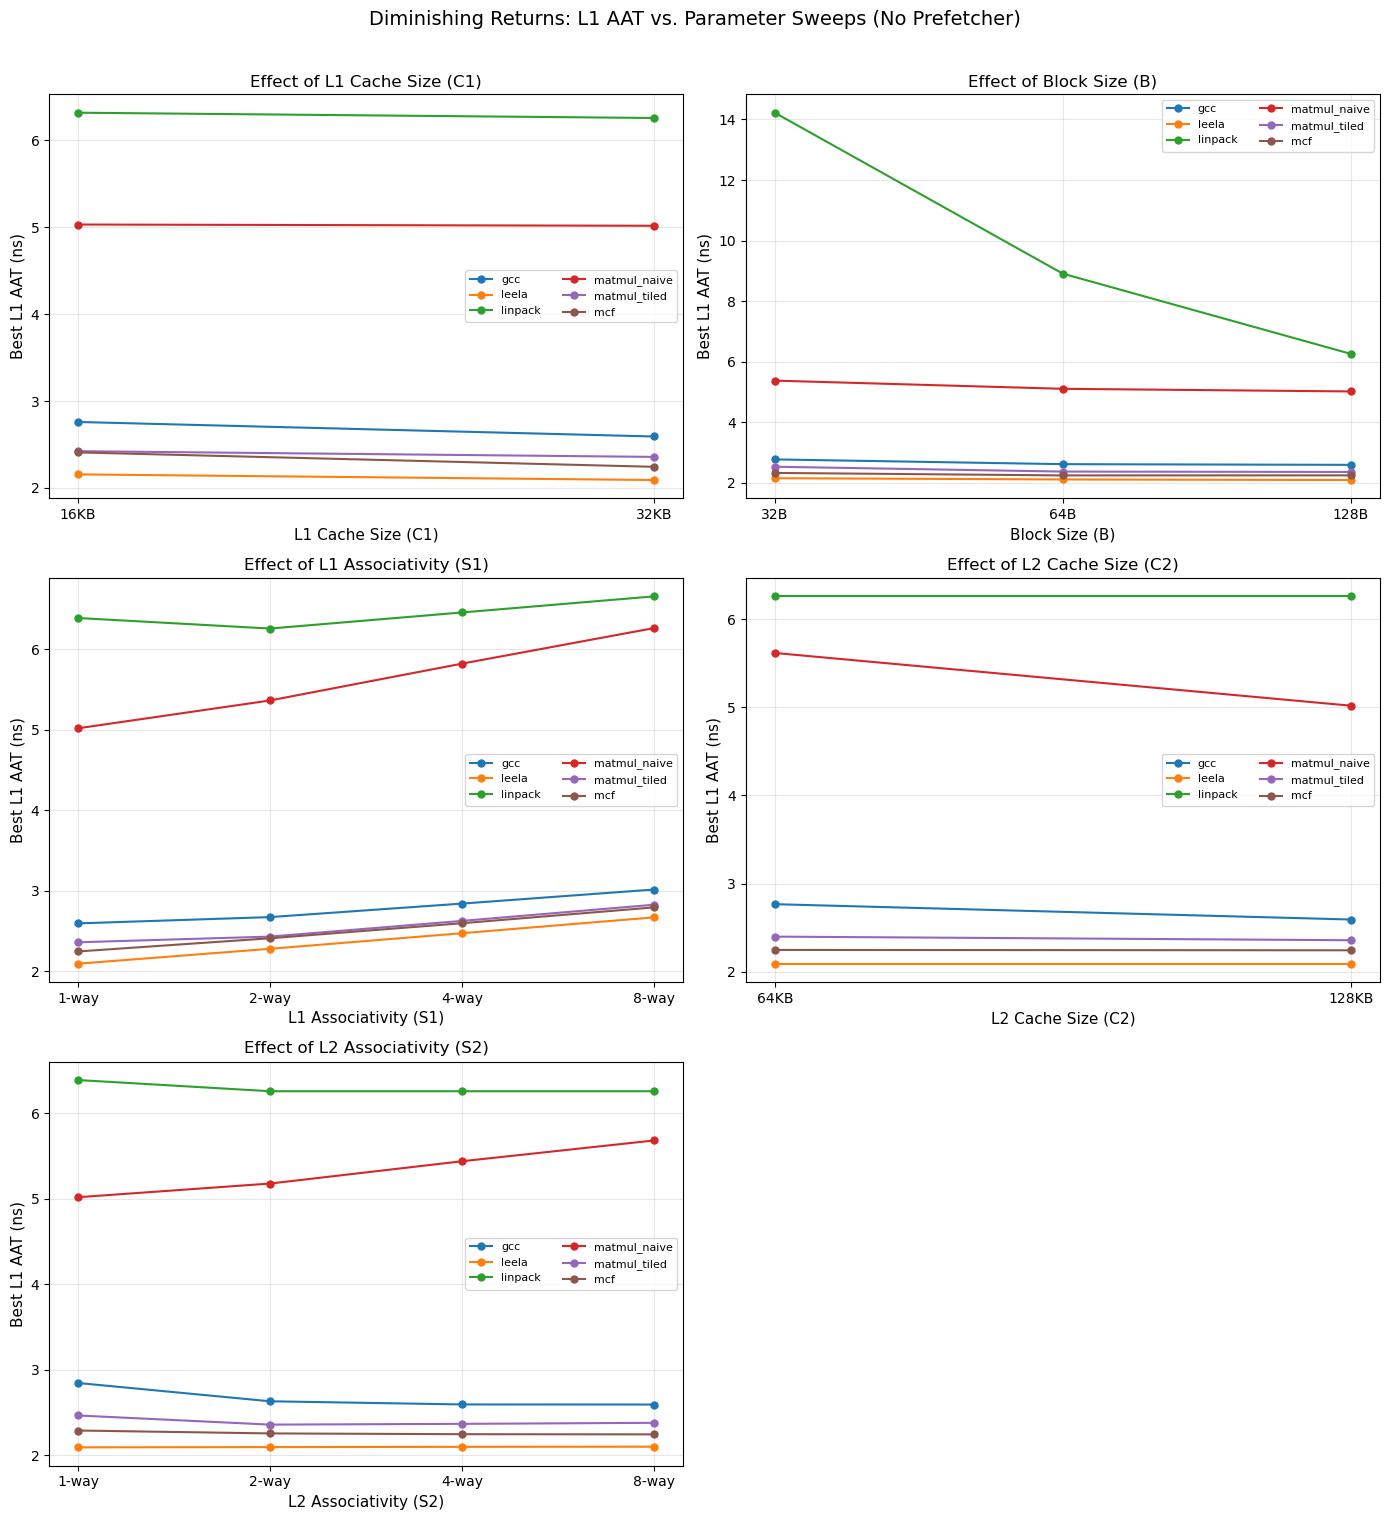

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle("Diminishing Returns: L1 AAT vs. Parameter Sweeps (No Prefetcher)", fontsize=14, y=1.01)

params_to_sweep = [
    ('C1', 'L1 Cache Size (C1)', [14, 15]),
    ('B',  'Block Size (B)', [5, 6, 7]),
    ('S1', 'L1 Associativity (S1)', [0, 1, 2, 3]),
    ('C2', 'L2 Cache Size (C2)', [16, 17]),
    ('S2', 'L2 Associativity (S2)', [0, 1, 2, 3]),
]

for idx, (param, label, vals) in enumerate(params_to_sweep):
    ax = axes[idx // 2][idx % 2]
    
    for t in traces:
        aats = []
        for v in vals:
            sub = df_none[(df_none['trace'] == t) & (df_none[param] == v)]
            if not sub.empty:
                aats.append(sub['L1_AAT'].min())
            else:
                aats.append(np.nan)
        ax.plot(vals, aats, 'o-', label=t, markersize=5)
    
    ax.set_xlabel(label, fontsize=11)
    ax.set_ylabel('Best L1 AAT (ns)', fontsize=11)
    ax.set_title(f'Effect of {label}', fontsize=12)
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(vals)
    if param == 'C1':
        ax.set_xticklabels([f'{2**v//1024}KB' for v in vals])
    elif param == 'C2':
        ax.set_xticklabels([f'{2**v//1024}KB' for v in vals])
    elif param == 'B':
        ax.set_xticklabels([f'{2**v}B' for v in vals])
    elif param in ('S1', 'S2'):
        ax.set_xticklabels([f'{2**v}-way' for v in vals])

axes[2][1].set_visible(False)
plt.tight_layout()
plt.show()

In [30]:
print("Diminishing Returns: Percentage Change of AAT (per parameter step (w/ No Prefetcher))\n")

for param, label, vals in params_to_sweep:
    print(f"\n{'─'*70}")
    print(f"  Parameter: {label}")
    print(f"  {'Trace':<15}", end="")
    for i in range(1, len(vals)):
        print(f"  {vals[i-1]}→{vals[i]:>4}", end="")
    print()
    
    for t in traces:
        print(f"  {t:<15}", end="")
        prev_aat = None
        for v in vals:
            sub = df_none[(df_none['trace'] == t) & (df_none[param] == v)]
            cur_aat = sub['L1_AAT'].min() if not sub.empty else np.nan
            if prev_aat is not None and not np.isnan(cur_aat) and not np.isnan(prev_aat):
                pct = (cur_aat - prev_aat) / prev_aat * 100
                print(f"  {pct:>+7.2f}%", end="")
            prev_aat = cur_aat
        print()

Diminishing Returns: Percentage Change of AAT (per parameter step (w/ No Prefetcher))


──────────────────────────────────────────────────────────────────────
  Parameter: L1 Cache Size (C1)
  Trace            14→  15
  gcc                -6.05%
  leela              -3.01%
  linpack            -0.97%
  matmul_naive       -0.28%
  matmul_tiled       -2.72%
  mcf                -6.89%

──────────────────────────────────────────────────────────────────────
  Parameter: Block Size (B)
  Trace            5→   6  6→   7
  gcc                -5.66%    -0.88%
  leela              -1.91%    -0.90%
  linpack           -37.38%   -29.75%
  matmul_naive       -5.02%    -1.70%
  matmul_tiled       -6.32%    -0.55%
  mcf                -3.57%    +0.09%

──────────────────────────────────────────────────────────────────────
  Parameter: L1 Associativity (S1)
  Trace            0→   1  1→   2  2→   3
  gcc                +3.01%    +6.29%    +6.17%
  leela              +8.85%    +8.52%    +7.98%
  linpa

### Key Takeaways from above
- **$C_1 (14\rightarrow 15)$:** Changing cache capacity from 14 to 15 yields small improvement (less than 5%) for most traces. 
- **$B: \{5,6,7\}$:** Larger blocks size helps with the trace: linpack and matmul_naive due to their spatial locality. But $B=7$ has dimishing return compares to $B=6$.
- **$S_1$ (associativity):** Going above 2-way (S1=1) hurts L1 AAT due to increased hit-time penalty (+0.2 per S1 step). S1=0 (direct-mapped) is optimal for most traces.
- **$C_2 (16\rightarrow 17)$:** Doubling L2 size helps some traces (gcc and matmul_naive), but minimal for other traces
- **$S_2$ (associativity):** 1-way L2 often wins because L2 hit-time penalty (+0.8 per S2 step) outweighs conflict-miss reduction for these trace sizes.

## 5. Metadata 

For each recommended configuration, I compute total overhead:
- **Tag bits per block** = Address bits − Index bits − Offset bits = $64 − (C − B − S) − B = 64 − C + S$
- **Metadata per block** = tag_bits + 1 (valid) + 1 (dirty) bits  
- **Number of blocks** = $2^{C−B}$
- **Total metadata** = num_blocks * metadata_per_block

In [31]:

ADDR_BITS = 64
print("Metedata Recommended Configuration\n")
print(f"\n{'Trace':<15} {'Level':>5} {'C':>3} {'B':>3} {'S':>3} "
      f"{'Data(KB)':>9} {'#Blocks':>8} {'TagBits':>8} {'Meta/Blk':>9} "
      f"{'TotalMeta':>12} {'Overhead%':>10}")
print("─" * 100)
total_meta_all = {}
for t in traces:
    best = best_configs[t]
    C1, B, S1 = int(best['C1']), int(best['B']), int(best['S1'])
    C2, S2 = int(best['C2']), int(best['S2'])
    
    total_meta = 0
    for level, C, S in [('L1', C1, S1), ('L2', C2, S2)]:
        num_blocks = 2 ** (C - B)
        index_bits = C - B - S
        tag_bits = ADDR_BITS - index_bits - B
        meta_per_block_bits = tag_bits + 1 + 1  # +valid +dirty
        total_meta_bits = num_blocks * meta_per_block_bits
        total_meta_bytes = total_meta_bits / 8
        data_bytes = 2 ** C
        overhead_pct = (total_meta_bytes / data_bytes) * 100
        total_meta += total_meta_bytes
        
        print(f"{t if level=='L1' else '':<15} {level:>5} {C:>3} {B:>3} {S:>3} "
              f"{data_bytes/1024:>9.1f} {num_blocks:>8} {tag_bits:>8} "
              f"{meta_per_block_bits:>9} {total_meta_bytes:>10.1f} B {overhead_pct:>8.2f}%")
    
    total_meta_all[t] = total_meta
    print(f"{'':>15} {'TOTAL':>5} {'':>3} {'':>3} {'':>3} "
          f"{'':>9} {'':>8} {'':>8} {'':>9} {total_meta:>10.1f} B")

print("\n Total Metadata per Recommended Config")
print("─" * 50)
for t in traces:
    best = best_configs[t]
    print(f"  {t:<15} {total_meta_all[t]:>8.1f} B  "
          f"(C1={int(best['C1'])},B={int(best['B'])},S1={int(best['S1'])},"
          f"C2={int(best['C2'])},S2={int(best['S2'])})")

Metedata Recommended Configuration


Trace           Level   C   B   S  Data(KB)  #Blocks  TagBits  Meta/Blk    TotalMeta  Overhead%
────────────────────────────────────────────────────────────────────────────────────────────────────
gcc                L1  15   7   0      32.0      256       49        51     1632.0 B     4.98%
                   L2  17   7   3     128.0     1024       50        52     6656.0 B     5.08%
                TOTAL                                                       8288.0 B
leela              L1  15   7   0      32.0      256       49        51     1632.0 B     4.98%
                   L2  16   7   0      64.0      512       48        50     3200.0 B     4.88%
                TOTAL                                                       4832.0 B
linpack            L1  15   7   1      32.0      256       50        52     1664.0 B     5.08%
                   L2  17   7   1     128.0     1024       48        50     6400.0 B     4.88%
                TOTAL     

## 6. Plus-One Prefetcher 

The Plus-One prefetcher fetches block (addr+1) into L2 on every L1 miss. I compare Plus-One vs. no prefetcher for the best config of each trace.

In [32]:
print("+1 Prefetcher vs No Prefetcher (best config per trace)\n")
print(f"\n{'Trace':<15} {'AAT(none)':>10} {'AAT(+1)':>10} {'Δ AAT':>8} {'% Improve':>10} "
      f"{'PF Issued':>10} {'PF Hits':>9} {'Hit Rate':>9}")
print("─" * 95)

for t in traces:
    sub_none = df_none[df_none['trace'] == t].sort_values('L1_AAT').iloc[0]
    C1, B, S1, C2, S2 = int(sub_none['C1']), int(sub_none['B']), int(sub_none['S1']), int(sub_none['C2']), int(sub_none['S2'])
    sub_p1 = df_plus1[(df_plus1['trace'] == t) & 
                       (df_plus1['C1'] == C1) & (df_plus1['B'] == B) & 
                       (df_plus1['S1'] == S1) & (df_plus1['C2'] == C2) & 
                       (df_plus1['S2'] == S2)]
    
    if not sub_p1.empty:
        p1 = sub_p1.iloc[0]
        delta = p1['L1_AAT'] - sub_none['L1_AAT']
        pct = delta / sub_none['L1_AAT'] * 100
        pf_hr = p1['PF_hits'] / p1['PF_issued'] * 100 if p1['PF_issued'] > 0 else 0
        print(f"{t:<15} {sub_none['L1_AAT']:>10.3f} {p1['L1_AAT']:>10.3f} {delta:>8.3f} "
              f"{pct:>+9.2f}% {int(p1['PF_issued']):>10} {int(p1['PF_hits']):>9} {pf_hr:>8.1f}%")
    else:
        print(f"{t:<15} {sub_none['L1_AAT']:>10.3f}   (no matching +1 config)")


print(f"\n Best +1 Prefetcher AAT across all configs:")
print("─" * 80)
for t in traces:
    sub = df_plus1[df_plus1['trace'] == t].sort_values('L1_AAT').iloc[0]
    none_best = df_none[df_none['trace'] == t]['L1_AAT'].min()
    delta = sub['L1_AAT'] - none_best
    pct = delta / none_best * 100
    print(f"{t:<15} AAT={sub['L1_AAT']:.3f} (vs {none_best:.3f} none, {pct:+.2f}%) "
          f"C1={int(sub['C1'])},B={int(sub['B'])},S1={int(sub['S1'])},"
          f"C2={int(sub['C2'])},S2={int(sub['S2'])}")

+1 Prefetcher vs No Prefetcher (best config per trace)


Trace            AAT(none)    AAT(+1)    Δ AAT  % Improve  PF Issued   PF Hits  Hit Rate
───────────────────────────────────────────────────────────────────────────────────────────────
gcc                  2.592      2.529   -0.063     -2.43%      13620     11946     87.7%
leela                2.091      2.064   -0.027     -1.29%       2132      1960     91.9%
linpack              6.257      2.654   -3.603    -57.58%      21131       339      1.6%
matmul_naive         5.017      4.852   -0.165     -3.29%     165669    163813     98.9%
matmul_tiled         2.357      2.254   -0.103     -4.37%       9203      8301     90.2%
mcf                  2.243      2.137   -0.106     -4.73%       2441      1066     43.7%

 Best +1 Prefetcher AAT across all configs:
────────────────────────────────────────────────────────────────────────────────
gcc             AAT=2.492 (vs 2.592 none, -3.86%) C1=15,B=6,S1=0,C2=17,S2=2
leela           AAT=2.

## 7. Markov & Hybrid Prefetcher

I examine how the Markov Table Size parameter $r$ (the number of entries per row) affects prefetcher peformance for both Markov and Hybrid modes. I will experiement with different $r$ values $$r ∈ {4, 16, 32, 64, 128, 256, 512}$$

In [33]:
print("Markov Prefecher: effects of r on L1 AAT\n")

r_vals = sorted(df_mark['r'].unique())
for t in traces:
    best_row = df_mark[df_mark['trace'] == t].sort_values('L1_AAT').iloc[0]
    C1, B, S1, C2, S2 = int(best_row['C1']), int(best_row['B']), int(best_row['S1']), int(best_row['C2']), int(best_row['S2'])
    
    print(f"\n{'─'*80}")
    print(f"  Trace: {t}  (best config: C1={C1},B={B},S1={S1},C2={C2},S2={S2})")
    print(f"  {'r':>6} {'L1_AAT':>9} {'L2_RHR':>8} {'PF_issued':>10} {'PF_hits':>10} {'PF_misses':>10} {'PF_HR%':>8}")
    
    sub = df_mark[(df_mark['trace'] == t) & 
                   (df_mark['C1'] == C1) & (df_mark['B'] == B) & 
                   (df_mark['S1'] == S1) & (df_mark['C2'] == C2) & 
                   (df_mark['S2'] == S2)].sort_values('r')
    
    for _, row in sub.iterrows():
        pf_hr = row['PF_hits'] / row['PF_issued'] * 100 if row['PF_issued'] > 0 else 0
        print(f"  {int(row['r']):>6} {row['L1_AAT']:>9.3f} {row['L2_RHR']:>8.3f} "
              f"{int(row['PF_issued']):>10} {int(row['PF_hits']):>10} "
              f"{int(row['PF_misses']):>10} {pf_hr:>7.1f}%")

Markov Prefecher: effects of r on L1 AAT


────────────────────────────────────────────────────────────────────────────────
  Trace: gcc  (best config: C1=15,B=6,S1=1,C2=17,S2=4)
       r    L1_AAT   L2_RHR  PF_issued    PF_hits  PF_misses   PF_HR%
       4     2.678    0.700       5380       5245        135    97.5%
      16     2.679    0.700       5380       5239        141    97.4%
      32     2.678    0.700       5380       5238        142    97.4%
      64     2.678    0.700       5380       5238        142    97.4%
     128     2.678    0.700       5380       5238        142    97.4%
     256     2.678    0.700       5380       5238        142    97.4%
     512     2.678    0.700       5380       5238        142    97.4%

────────────────────────────────────────────────────────────────────────────────
  Trace: leela  (best config: C1=15,B=6,S1=1,C2=16,S2=4)
       r    L1_AAT   L2_RHR  PF_issued    PF_hits  PF_misses   PF_HR%
       4     2.297    0.378        341        341   

In [34]:
print("Hybrid Prefetcher: Effect of r on L1 AAT")

for t in traces:
    best_row = df_hyb[df_hyb['trace'] == t].sort_values('L1_AAT').iloc[0]
    C1, B, S1, C2, S2 = int(best_row['C1']), int(best_row['B']), int(best_row['S1']), int(best_row['C2']), int(best_row['S2'])
    
    print(f"\n{'─'*80}")
    print(f"  Trace: {t}  (best config: C1={C1},B={B},S1={S1},C2={C2},S2={S2})")
    print(f"  {'r':>6} {'L1_AAT':>9} {'L2_RHR':>8} {'PF_issued':>10} {'PF_hits':>10} {'PF_misses':>10} {'PF_HR%':>8}")
    
    sub = df_hyb[(df_hyb['trace'] == t) & 
                  (df_hyb['C1'] == C1) & (df_hyb['B'] == B) & 
                  (df_hyb['S1'] == S1) & (df_hyb['C2'] == C2) & 
                  (df_hyb['S2'] == S2)].sort_values('r')
    
    for _, row in sub.iterrows():
        pf_hr = row['PF_hits'] / row['PF_issued'] * 100 if row['PF_issued'] > 0 else 0
        print(f"  {int(row['r']):>6} {row['L1_AAT']:>9.3f} {row['L2_RHR']:>8.3f} "
              f"{int(row['PF_issued']):>10} {int(row['PF_hits']):>10} "
              f"{int(row['PF_misses']):>10} {pf_hr:>7.1f}%")

Hybrid Prefetcher: Effect of r on L1 AAT

────────────────────────────────────────────────────────────────────────────────
  Trace: gcc  (best config: C1=15,B=6,S1=1,C2=17,S2=3)
       r    L1_AAT   L2_RHR  PF_issued    PF_hits  PF_misses   PF_HR%
       4     2.546    0.818      12889      10591       2298    82.2%
      16     2.546    0.818      12889      10582       2307    82.1%
      32     2.546    0.818      12889      10582       2307    82.1%
      64     2.546    0.818      12889      10582       2307    82.1%
     128     2.546    0.818      12889      10582       2307    82.1%
     256     2.546    0.818      12889      10582       2307    82.1%
     512     2.546    0.818      12889      10582       2307    82.1%

────────────────────────────────────────────────────────────────────────────────
  Trace: leela  (best config: C1=15,B=6,S1=1,C2=16,S2=3)
       r    L1_AAT   L2_RHR  PF_issued    PF_hits  PF_misses   PF_HR%
       4     2.264    0.636       1243        931    

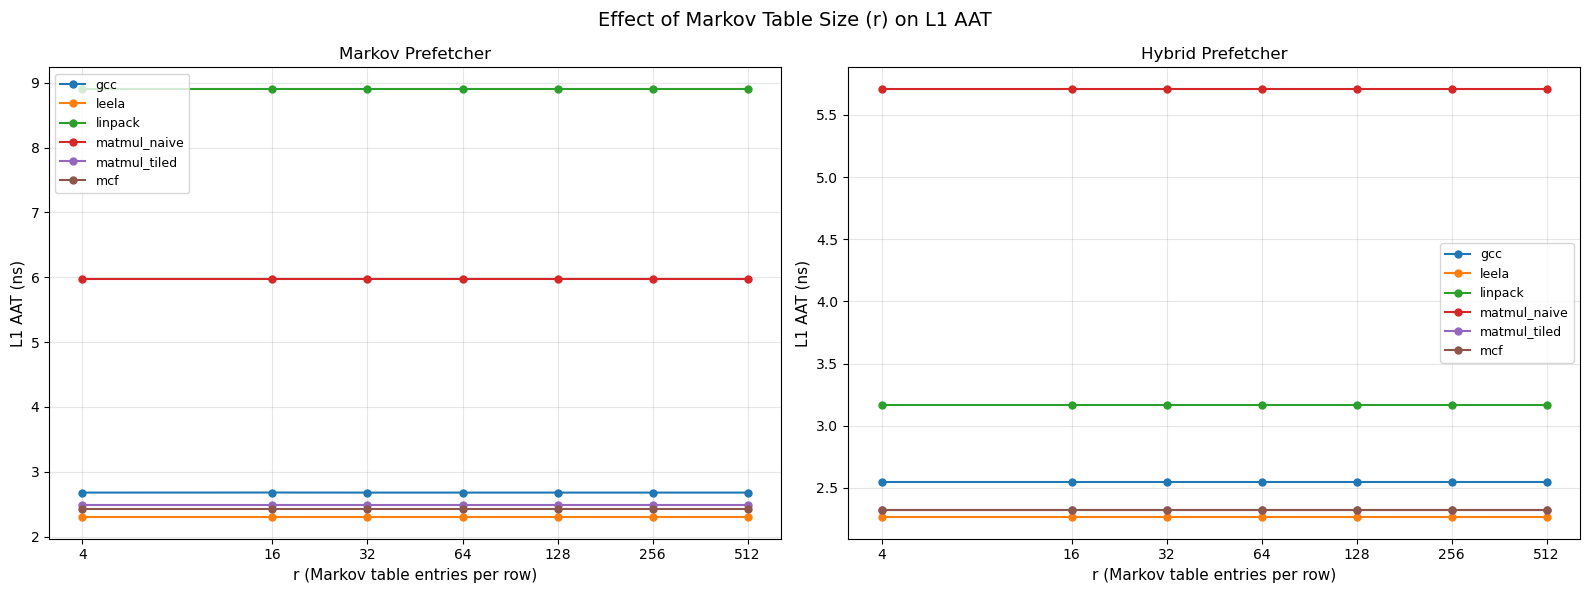

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Effect of Markov Table Size (r) on L1 AAT", fontsize=14)

for ax_idx, (pf_name, df_pf) in enumerate([('Markov', df_mark), ('Hybrid', df_hyb)]):
    ax = axes[ax_idx]
    for t in traces:
        best_row = df_pf[df_pf['trace'] == t].sort_values('L1_AAT').iloc[0]
        C1, B, S1, C2, S2 = int(best_row['C1']), int(best_row['B']), int(best_row['S1']), int(best_row['C2']), int(best_row['S2'])
        
        sub = df_pf[(df_pf['trace'] == t) & 
                     (df_pf['C1'] == C1) & (df_pf['B'] == B) & 
                     (df_pf['S1'] == S1) & (df_pf['C2'] == C2) & 
                     (df_pf['S2'] == S2)].sort_values('r')
        
        ax.plot(sub['r'], sub['L1_AAT'], 'o-', label=t, markersize=5)
    
    ax.set_xlabel('r (Markov table entries per row)', fontsize=11)
    ax.set_ylabel('L1 AAT (ns)', fontsize=11)
    ax.set_title(f'{pf_name} Prefetcher', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    ax.set_xticks(r_vals)
    ax.set_xticklabels([str(r) for r in r_vals])

plt.tight_layout()
plt.show()

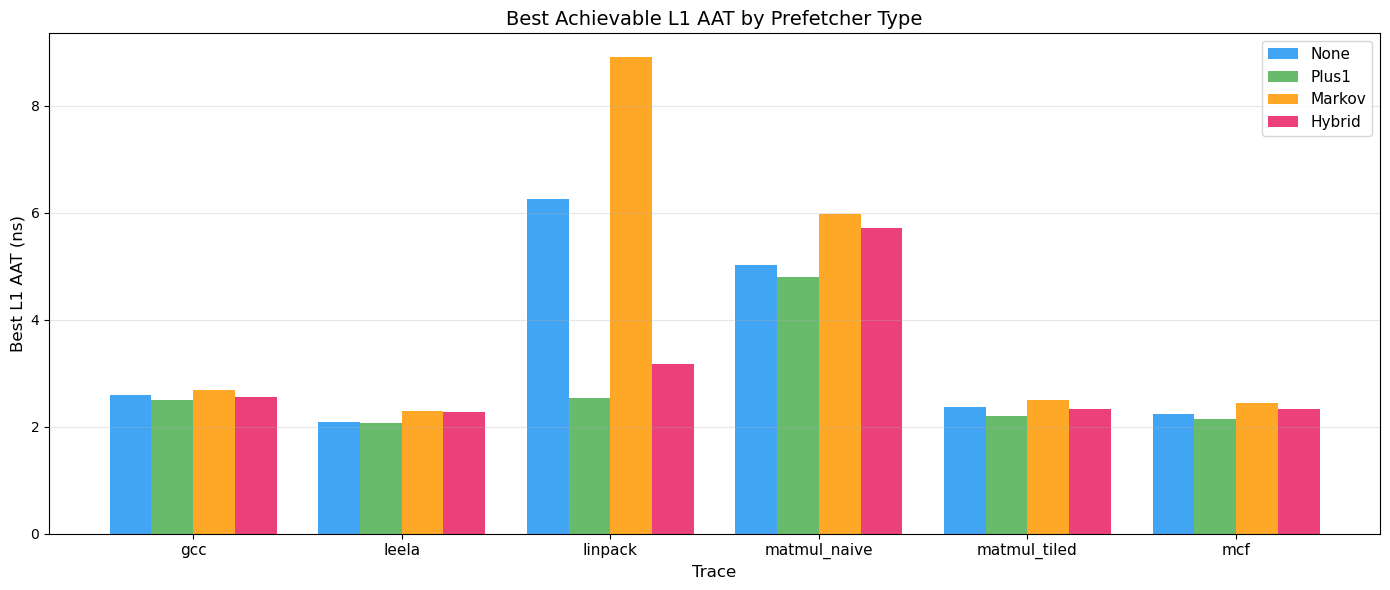

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(traces))
width = 0.2
colors = ['#2196F3', '#4CAF50', '#FF9800', '#E91E63']

for i, pf in enumerate(['none', 'plus1', 'markov', 'hybrid']):
    aats = []
    for t in traces:
        sub = df_all[(df_all['trace'] == t) & (df_all['prefetch'] == pf)]
        aats.append(sub['L1_AAT'].min() if not sub.empty else 0)
    ax.bar(x + i * width, aats, width, label=pf.capitalize(), color=colors[i], alpha=0.85)

ax.set_xlabel('Trace', fontsize=12)
ax.set_ylabel('Best L1 AAT (ns)', fontsize=12)
ax.set_title('Best Achievable L1 AAT by Prefetcher Type', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(traces, fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Markov and Hybrid Prefetchers Results

### Markov Prefetcher
**r has minimal/no impact on AAT**. For all six traces, varying r from 4 to 512 produces virtually no change in L1 AAT. The curves in the plot are essentially flat horizontal lines. For all six traces, changing $r$ from $4$ to $512$ prorduces no change in L1 AAT. The curve in the plot are basically all horizontal lines. $r$ controls the max number of successor entries per row in the markov table. It could be that the traces have very few distinct successors per block. Of rexample, in a sequentail array traversal like linpack, block A is almost always followed by block $A+1$. The Markov Table would only need 1 entry per row to capture this optimal prefetching logic. Even for traces with branching patterns like gcc, the number of distinct successors per block almost dont exceed 4. So, $r=4$ captures all the meaningful transitions. Increasing up to 512 introduces additional overhead without producing much value. 


### Hybrid Prefetcher (Plus-One + Markov)
The hybrid prefetcher helps, but only selectively across the different traces. It shows minimal improvement over the plu-one because plus-one spatial stream prediction is doing most of the work while the markov only add minial gains in speedup. That explains why $r$ is irrelevant for the hybrid ATT just like the markov prefetcher. On traces like linpack and matmul_naive where temporal transitions are noisy, the extra markov preftecher can increase cache pollution. It pushes out useful lines and could sometimes offset any benefit from occasional correct predictions. 

### Plus-One Prefetcher
The **Plus-One prefetcher provides the best AAT improvement** across all traces with the simplest implementation. Markov and Hybrid prefetchers add spatial complexity with minimal additional benefit. The table size r has negligible impact. Thus, the smallest $r$ where $r=4$ is sufficient to provide the best improvements. +1 prefetcher is most efficient on linpacka nd matmul_tiled because of sequentially array traversals and tiling that produces strong spatial locality.

## 9. Recommended Configurations

In [37]:
print("Final recommended configuraitons (Overall Best AAT per Trace)")
print(f"\n{'Trace':<15} {'Prefetch':<10} {'r':>4} {'C1':>3} {'B':>3} {'S1':>3} {'C2':>3} {'S2':>3} "
      f"{'L1(KB)':>7} {'L2(KB)':>7} {'BlkSz':>6} "
      f"{'L1_AAT':>8} {'L1_HR':>6} {'L2_RHR':>7} {'L2_AAT':>8} {'Meta(B)':>8}")
print("─" * 120)

for t in traces:
    sub = df_all[df_all['trace'] == t].sort_values('L1_AAT').iloc[0]
    C1, B, S1, C2, S2 = int(sub['C1']), int(sub['B']), int(sub['S1']), int(sub['C2']), int(sub['S2'])
    
    num_l1_blocks = 2 ** (C1 - B)
    num_l2_blocks = 2 ** (C2 - B)
    l1_tag = 64 - (C1 - B - S1) - B
    l2_tag = 64 - (C2 - B - S2) - B
    meta = (num_l1_blocks * (l1_tag + 2) + num_l2_blocks * (l2_tag + 2)) / 8
    
    print(f"{t:<15} {sub['prefetch']:<10} {int(sub['r']):>4} "
          f"{C1:>3} {B:>3} {S1:>3} {C2:>3} {S2:>3} "
          f"{2**C1/1024:>7.0f} {2**C2/1024:>7.0f} {2**B:>6} "
          f"{sub['L1_AAT']:>8.3f} {sub['L1_HR']:>6.3f} {sub['L2_RHR']:>7.3f} "
          f"{sub['L2_AAT']:>8.3f} {meta:>8.1f}")

Final recommended configuraitons (Overall Best AAT per Trace)

Trace           Prefetch      r  C1   B  S1  C2  S2  L1(KB)  L2(KB)  BlkSz   L1_AAT  L1_HR  L2_RHR   L2_AAT  Meta(B)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
gcc             plus1         0  15   6   0  17   2      32     128     64    2.492  0.973   0.878   18.188  16320.0
leela           plus1         0  15   7   0  17   0      32     128    128    2.064  0.996   0.921   14.934   7904.0
linpack         plus1         0  15   7   0  17   0      32     128    128    2.527  0.946   0.980    9.736   7904.0
matmul_naive    plus1         0  15   5   0  17   0      32     128     32    4.789  0.667   0.994    8.370  31616.0
matmul_tiled    plus1         0  15   6   0  17   1      32     128     64    2.201  0.987   0.911   15.117  16064.0
mcf             plus1         0  15   6   0  17   3      32     128     64    2.137  0.995   0.745   28.164  16576

### Summary
- **B=7 (128-byte blocks)** benefits all traces by amortizing the DRAM access penalty ($64 + 128/8 \times 2 = 96$ cycles) over more useful bytes
- **Low associativity** ($S1=0 direct-mapped, S2=0 or S2=1$) is best because the hit-time penalty per doubling of ways (L1: +0.2, L2: +0.8) is steep
- **$C_1=15$ (32 KB)** helps gcc/matmul. $C_1=14$ (16 KB) for leela/mcf
- **$C_2=17$ (128 KB)** helps workloads with larger working sets like (gcc, matmul_naive)
- **Plus-One prefetcher** is the best prefetcher due to it's simple, low overhead nature providing the highest accuracy.